## Importing Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install yfinance --upgrade --no-cache-dir
from pandas_datareader import data as pdr
import yfinance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

## Fetch the Data

In [15]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("CLX", start="2009-01-01", end ="2017-12-31").reset_index()
df_full.to_csv('CLX.csv',index=False)       #CLOROX
df_full.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-12-31,54.730000,56.000000,54.650002,55.560001,38.662643,1051100
1,2009-01-02,55.900002,56.500000,55.349998,56.369999,39.226307,870300
2,2009-01-05,56.360001,56.599998,55.810001,56.230000,39.128891,1109200
3,2009-01-06,56.360001,56.380001,54.980000,55.529999,38.641785,1707800
4,2009-01-07,55.000000,55.849998,54.220001,54.619999,38.008530,1748200


## Defining the Q-Learning Agent

In [16]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f'
                    % (t, close[t], invest, initial_money)) 
            else:
                print('day %d, hold on, total balance %f'
                      % (t, initial_money))
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

## Training the Agent

In [17]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 730, checkpoint = 10, initial_money = initial_money)           #from Jan 2018 to Dec 2019

C:\Users\Parikshit Ghosh\anaconda3\envs\newenvt\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Parikshit Ghosh\anaconda3\envs\newenvt\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\Parikshit Ghosh\anaconda3\envs\newenvt\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 74.620102.3, cost: 0.051326, total money: 10074.620102
epoch: 20, total rewards: 73.870090.3, cost: 0.045720, total money: 10073.870090
epoch: 30, total rewards: 51.980106.3, cost: 0.038604, total money: 10051.980106
epoch: 40, total rewards: 58.710159.3, cost: 0.036109, total money: 10058.710159
epoch: 50, total rewards: 34.640156.3, cost: 0.034303, total money: 10034.640156
epoch: 60, total rewards: 57.850128.3, cost: 0.033006, total money: 10057.850128
epoch: 70, total rewards: 59.240120.3, cost: 0.031860, total money: 10059.240120
epoch: 80, total rewards: 42.580109.3, cost: 0.030826, total money: 10042.580109
epoch: 90, total rewards: 65.710094.3, cost: 0.029915, total money: 10065.710094
epoch: 100, total rewards: 61.180126.3, cost: 0.029017, total money: 10061.180126
epoch: 110, total rewards: 75.930042.3, cost: 0.028191, total money: 10075.930042
epoch: 120, total rewards: 45.310074.3, cost: 0.027310, total money: 10045.310074
epoch: 130, total rewards

## Testing the Agent

In [18]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0, hold on, total balance 10000.000000
day 1, hold on, total balance 10000.000000
day 2, hold on, total balance 10000.000000
day 3, hold on, total balance 10000.000000
day 4, hold on, total balance 10000.000000
day 5, hold on, total balance 10000.000000
day 6, hold on, total balance 10000.000000
day 7, hold on, total balance 10000.000000
day 8: buy 1 unit at price 52.529999, total balance 9947.470001
day 9, hold on, total balance 9947.470001
day 10, sell 1 unit at price 50.930000, investment -3.045876 %, total balance 9998.400002
day 11: buy 1 unit at price 51.360001, total balance 9947.040001
day 12, sell 1 unit at price 50.299999, investment -2.063866 %, total balance 9997.340000
day 13, hold on, total balance 9997.340000
day 14, hold on, total balance 9997.340000
day 15, hold on, total balance 9997.340000
day 16, hold on, total balance 9997.340000
day 17, hold on, total balance 9997.340000
day 18, hold on, total balance 9997.340000
day 19, hold on, total balance 9997.340000
day 

## Plotting the Signals

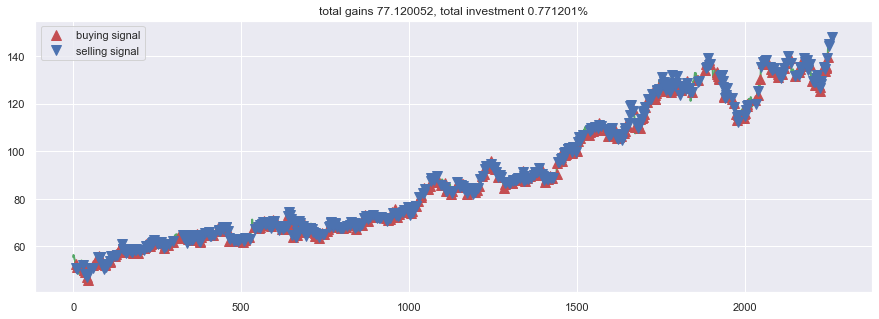

In [20]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='g', lw=2.)
plt.plot(close, '^', markersize=10, color='r', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='b', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()